In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Import image with road line 

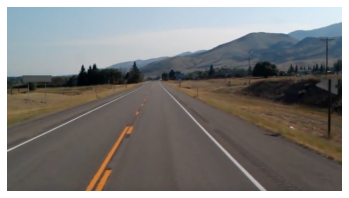

In [2]:
image = cv2.imread("test_image.jpg")
#cv2.imshow("input_image", image)

lanelines_image = np.copy(image)

plt.axis("off")
plt.imshow(cv2.cvtColor(lanelines_image, cv2.COLOR_BGR2RGB))
plt.show()


# Pre-process the image
## 1)Turn the image to gray
## 2)blury the image
## 3)Applied canny edge detection

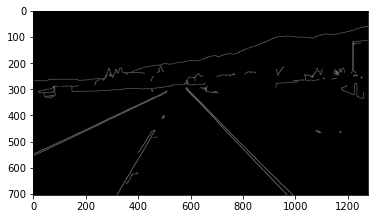

In [3]:
# Use canny_edge to detect of edge in the image 
def canny_edge(image):
    lanelines_image = np.copy(image)
    gray_conversion = cv2.cvtColor(lanelines_image, cv2.COLOR_RGB2GRAY)
    blur_conversion = cv2.GaussianBlur(gray_conversion, (5,5), 0)
    canny_conversion = cv2.Canny(blur_conversion, 50, 150)
    
    return canny_conversion

canny_image = canny_edge(lanelines_image)

plt.imshow(cv2.cvtColor(canny_image, cv2.COLOR_BGR2RGB))
plt.show()

# Masking the region of interest
1) Select the road line region\
In this case, we use (200, Image_height), (1100, Image_height), (551, 250)

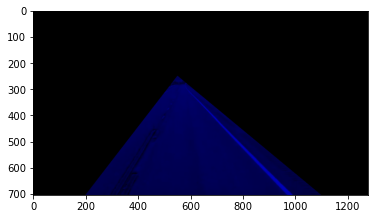

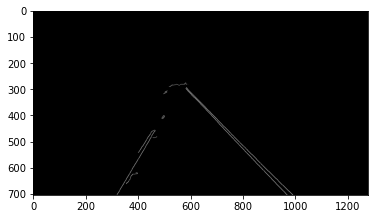

In [4]:
#choose the region of intereset
def reg_of_interest(image):
    Image_height = image.shape[0]
    polygons = np.array([[(200, Image_height), (1100, Image_height), (551, 250)]])

    image_mask = np.zeros_like(image)
    cv2.fillPoly(image_mask, polygons, 255)
    masking_image = cv2.bitwise_and(image, image_mask)
    return masking_image

display_image = reg_of_interest(lanelines_image)
plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
plt.show()
    
cropped_image = reg_of_interest(canny_image)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.show()



# Applying the Hough transform on interest region

In [5]:
lane_lines = cv2.HoughLinesP(cropped_image, 2, np.pi / 180, 100, 
np.array([]), minLineLength=40, maxLineGap=5)

# Display the line in image

In [6]:
# function to display the line
def show_lines(image, lines):
    lines_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
             X1, Y1, X2, Y2 = line.reshape(4)
             cv2.line(lines_image, (X1, Y1), (X2, Y2), (255, 0, 0), 10)
    return lines_image 

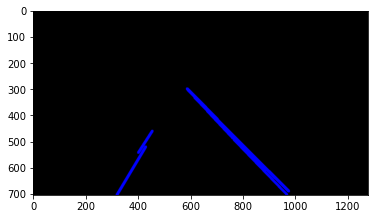

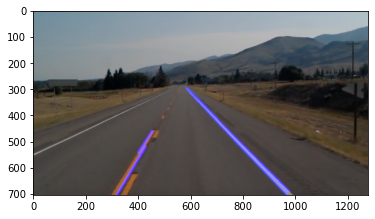

In [7]:
draft_image = show_lines(lanelines_image, lane_lines)
plt.imshow(cv2.cvtColor(draft_image, cv2.COLOR_BGR2RGB))
plt.show()


combine_image = cv2.addWeighted(lanelines_image, 0.8, draft_image, 1, 1)
plt.imshow(cv2.cvtColor(combine_image, cv2.COLOR_BGR2RGB))
plt.show()

# Optimizing the dected road markings

In [8]:
def make_coordinates(image, line_parameters):
    try:
        slope, intercept = line_parameters
    except TypeError:
        slope, intercept = 0.001,0
          #slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int((y1 * (3/5)))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [9]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameter = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameter[0]
        intercept = parameter[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis = 0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])

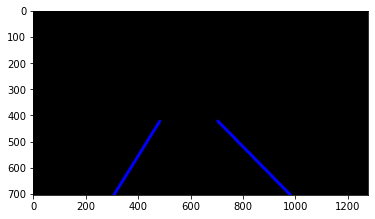

In [10]:
averaged_lines = average_slope_intercept(lanelines_image, lane_lines)
line_image = show_lines(lanelines_image, averaged_lines)

plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.show()

# Display the full output

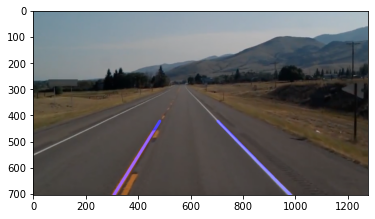

In [11]:
#lanelines_image is the copy of origin
combine_image = cv2.addWeighted(lanelines_image, 0.8, line_image, 1, 1)

plt.imshow(cv2.cvtColor(combine_image, cv2.COLOR_BGR2RGB))
plt.show()

# Line detection on video
unblock to play the video, click q to quiet video

In [12]:
cap = cv2.VideoCapture("test2.mp4")

In [13]:
"""
while(cap.isOpened()):
            _, frame = cap.read()
            canny_image = canny_edge(frame)
            cropped_canny = reg_of_interest(canny_image)
            lines = cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100,             np.array([]), minLineLength=40,maxLineGap=5)
            averaged_lines = average_slope_intercept(frame, lines)
            line_image = show_lines(frame, averaged_lines)
            combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
            cv2.imshow("result", combo_image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
cap.release()
cv2.waitKey(0)
cv2.destroyAllWindows()
"""


'\nwhile(cap.isOpened()):\n            _, frame = cap.read()\n            canny_image = canny_edge(frame)\n            cropped_canny = reg_of_interest(canny_image)\n            lines = cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100,             np.array([]), minLineLength=40,maxLineGap=5)\n            averaged_lines = average_slope_intercept(frame, lines)\n            line_image = show_lines(frame, averaged_lines)\n            combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)\n            cv2.imshow("result", combo_image)\n            if cv2.waitKey(1) & 0xFF == ord(\'q\'):\n                break\ncap.release()\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n'